# 1. AirPassengers 데이터셋을 이용한 시계열 예측

###  library load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(9,6)
import warnings
warnings.filterwarnings("ignore")

import pmdarima as pm
from inspect import signature
from tbats import TBATS, BATS
from arch import arch_model
from arch.data import sp500

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

###  AirPassengers 로드 & 기본 전처리 

In [2]:
ap = pd.read_csv("./data/AirPassengers.csv", parse_dates=["Month"], index_col="Month")
ap = ap.asfreq("MS")  
y = ap["#Passengers"].astype(float)

display(y)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Freq: MS, Name: #Passengers, Length: 144, dtype: float64

### 로그 변환(분산 안정화)
- 추세↑ + 계절성(12개월) + 변동성 증가(분산 비정상)

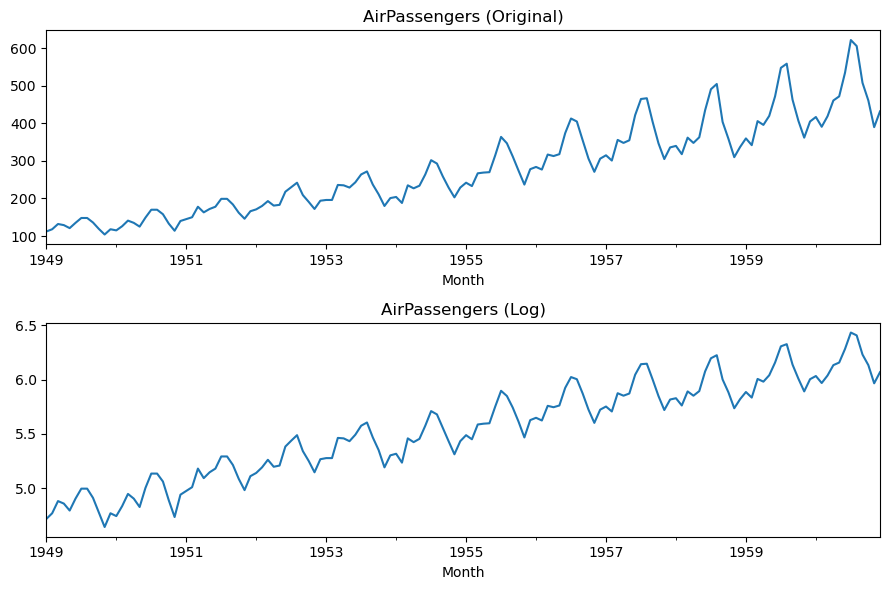

In [3]:
y_log = np.log(y)

fig, ax = plt.subplots(2, 1)
y.plot(ax=ax[0], title="AirPassengers (Original)")
y_log.plot(ax=ax[1], title="AirPassengers (Log)")
plt.tight_layout()
plt.show()

###  STL 분해
- Trend: 완만한 증가
- Seasonal: 12개월 주기 반복
- Residual: 패턴 없음 → 모델링 준비 OK

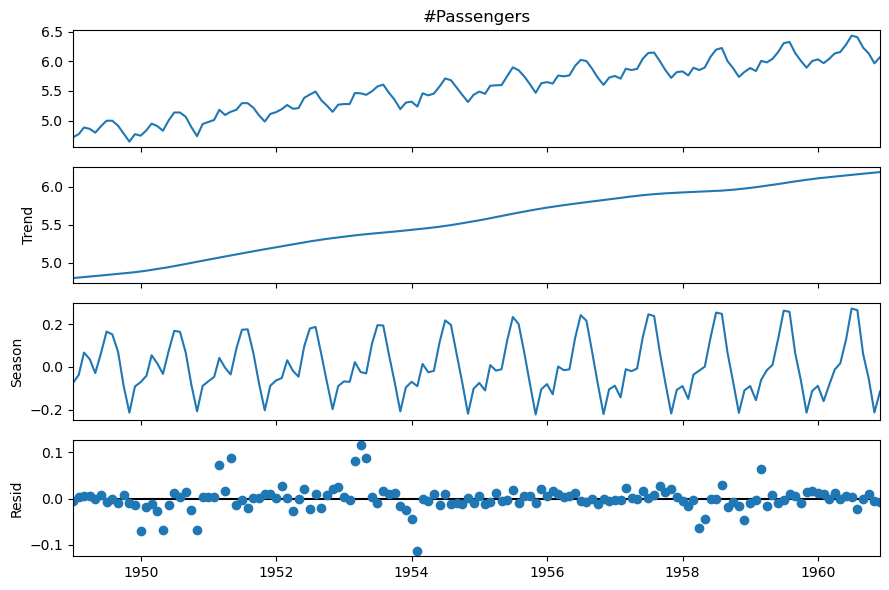

In [4]:
stl = STL(y_log, period=12, robust=True)
res = stl.fit()
res.plot()
plt.show()

### 정상성 검사 (ADF/KPSS)
- 로그만 취한 시계열은 추세/계절성 때문에 비정상
- 1차 차분(d=1) + 12계절 차분(D=1) 후에는 ADF·KPSS가 모두 정상성을 지지

In [5]:
def adf_print(x, name="series"):
    stat, p, *_ = adfuller(x.dropna())
    print(f"ADF[{name}] p-value:", p)

def kpss_print(x, name="series"):
    stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")
    print(f"KPSS[{name}] p-value:", p)

adf_print(y_log, "log(y)")
kpss_print(y_log, "log(y)")

ADF[log(y)] p-value: 0.42236677477038814
KPSS[log(y)] p-value: 0.01


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_10984\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### 차분 후 정상성 검사
- ADF[log(y) 1차 + 계절(12) 차분] p = 0.00025 (< 0.05)
  - 단위근 없음 → 정상성 달성
- KPSS[log(y) 1차 + 계절(12) 차분] p = 0.1 (≥ 0.1로 캡됨)
  - 정상성 귀무를 기각하지 못함 → 정상성에 문제 없음으로 해석

In [6]:
dy  = y_log.diff().dropna()      
Ddy = dy.diff(12).dropna()          

adf_print(Ddy, "log(y) diff1 & seas12")
kpss_print(Ddy, "log(y) diff1 & seas12")

ADF[log(y) diff1 & seas12] p-value: 0.00024859123113839645
KPSS[log(y) diff1 & seas12] p-value: 0.1


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_10984\3455055735.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, *_ = kpss(x.dropna(), regression="c", nlags="auto")


#### ACF/PACF
- ACF 12배수에서 유의 → 계절 MA(Q) 후보
- PACF 12배수에서 유의 → 계절 AR(P) 후보   
→ 작은 그리드로 SARIMA 탐색 필요

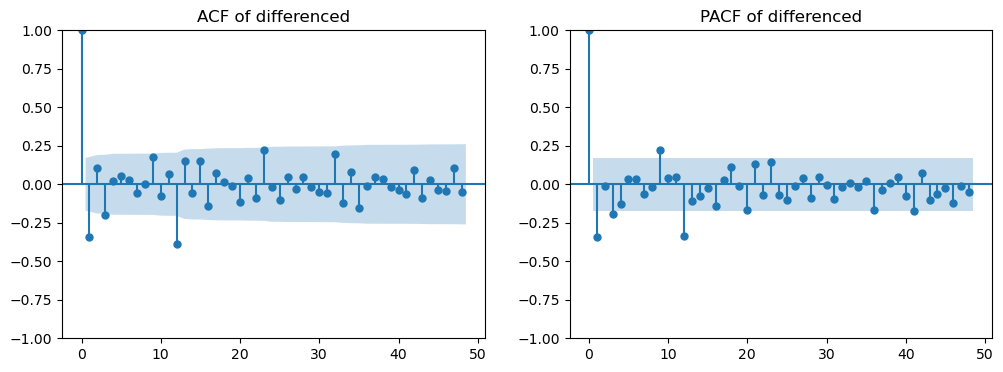

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

plot_acf(Ddy, lags=48, ax=ax[0])
ax[0].set_title("ACF of differenced")
plot_pacf(Ddy, lags=48, ax=ax[1])
ax[1].set_title("PACF of differenced")
plt.show()

### ARIMA 학습 & 예측

#### Train/Test Split
- 마지막 24개월을 테스트 구간으로 사용
- 로그 변환 / 차분 X
  - AutoARIMA(boxcox=True) 사용 시 내부적으로는 로그(또는 그에 준한 Box-Cox) 변환이 적용
  - 예측은 역변환 후 반환 

In [8]:
m = 12
h = 24
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

print("Train:", y_train.index.min().date(), "→", y_train.index.max().date(), "| N:", len(y_train))
print("Test :", y_test.index.min().date(),  "→", y_test.index.max().date(),  "| N:", len(y_test))

Train: 1949-01-01 → 1958-12-01 | N: 120
Test : 1959-01-01 → 1960-12-01 | N: 24


#### 함수 정의 
- 평가 함수

In [9]:
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
def mape(y_true, y_pred): return float(np.mean(np.abs((y_true - y_pred) / y_true))) * 100
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return float(np.mean(np.abs(y_true - y_pred) / denom)) * 100
def print_scores(tag, y_true, y_pred):
    print(f"[{tag}]  RMSE={rmse(y_true, y_pred):.3f}  "
          f"MAPE={mape(y_true, y_pred):.2f}%  sMAPE={smape(y_true, y_pred):.2f}%")

- 정합성 함수 (Series로 변환 + 인덱스/이름 강제)

In [10]:
def as_series(x, index, name):
    arr = np.asarray(getattr(x, "values", x)).ravel()
    return pd.Series(arr, index=index, name=name, dtype="float64")

- 시각화 함수 

In [11]:
def plot_model(title, y_train, y_test, y_pred, ci_df=None):
    if not hasattr(y_pred, "index"):
        y_pred = pd.Series(np.asarray(y_pred).ravel(), index=y_test.index, name="Forecast")
    else:
        y_pred = pd.Series(np.asarray(getattr(y_pred, "values", y_pred)).ravel(),
                           index=y_pred.index, name=getattr(y_pred, "name", "Forecast"))

    if ci_df is not None:
        ci_df = (pd.DataFrame(ci_df, index=y_pred.index).rename(columns=lambda c: str(c).lower()).reindex(y_pred.index))
        if not {"lower","upper"}.issubset(set(ci_df.columns)):
            ci_df = ci_df.iloc[:, :2]
            ci_df.columns = ["lower","upper"]
        ci_df = ci_df.apply(pd.to_numeric, errors="coerce")
        mask = np.isfinite(ci_df["lower"].to_numpy()) & np.isfinite(ci_df["upper"].to_numpy())
        ci_df = ci_df.loc[mask]

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(y_train.index, y_train.values, label="Train",
            color="#6481BD", linewidth=1.5, zorder=1)
    ax.plot(y_test.index, y_test.values, label="Test",
            color="#699E69" , linewidth=1.5, zorder=2)
    if ci_df is not None and len(ci_df) > 0:
        ax.fill_between(ci_df.index, ci_df["lower"].to_numpy(), ci_df["upper"].to_numpy(),
                        alpha=0.2, color="#B4B3B680", label=f"{y_pred.name} 95% CI", zorder=3)
    ax.plot(y_pred.index, y_pred.values, label=y_pred.name,
            color="#D8496D", linewidth=1.5, zorder=4)
    ax.set_title(title); ax.legend(); plt.tight_layout(); plt.show()

#### SARIMA (AutoARIMA)
- 선택 모형: ARIMA(2,0,0)(0,1,0)[12] + intercept
- 적합도: AIC(≈808.9), BIC(≈819.6)
- summary
  - Ljung–Box p=0.93 > 0.05 → 잔차 자기상관 없음(독립성 양호)
  - Jarque–Bera p=0.44 > 0.05 → 정규성 가설을 기각할 근거 없음(잔차는 대체로 정규에 부합)      
    다만 표본이 크지 않아 꼬리 두꺼움이 완전히 배제된다고 단정할 수는 없음 → Q–Q plot로 보조 점검
  - Heteroskedasticity H=1.41, Prob(H)=0.31 > 0.05 → 동분산 가설을 기각하지 못함(뚜렷한 이분산 증거 없음)

In [12]:
sarima = pm.AutoARIMA(seasonal=True, m=m, stepwise=True, suppress_warnings=True, 
                      trace=True, error_action="ignore", boxcox=True, max_D=3).fit(y_train)
sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.749, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.95 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.10 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.60 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.17 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Thu, 11 Sep 2025   AIC                            808.863
Time:                                    16:53:33   BIC                            819.592
Sample:                                01-01-1949   HQIC                           813.213
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[SARIMA(auto)]  RMSE=47.226  MAPE=9.44%  sMAPE=9.97%


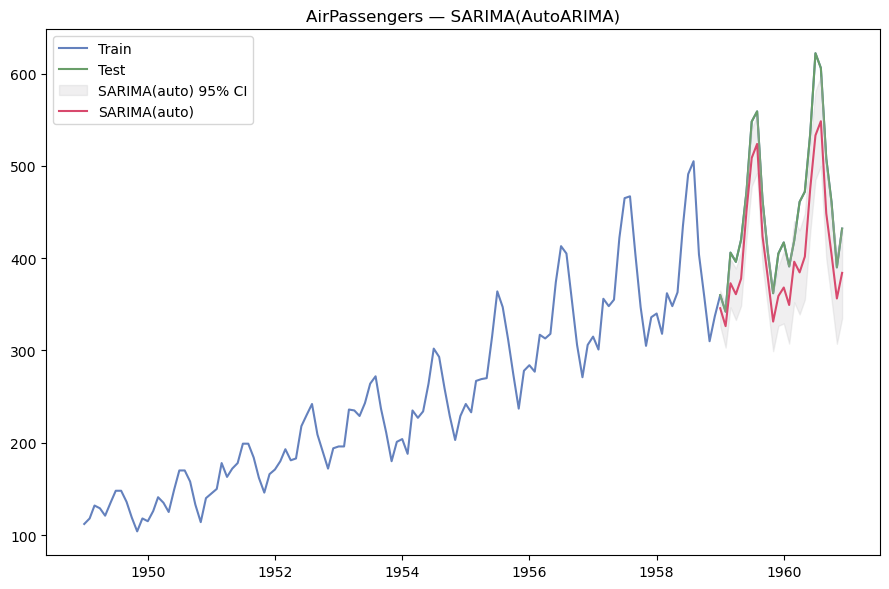

In [13]:
fc_sarima, ci = sarima.predict(n_periods=len(y_test), return_conf_int=True, alpha=0.05)
fc_sarima = as_series(fc_sarima, y_test.index, "SARIMA(auto)")
ci_sarima = pd.DataFrame(np.asarray(ci), index=y_test.index, columns=["lower","upper"]).astype(float)

print_scores("SARIMA(auto)", y_test, fc_sarima)
plot_model("AirPassengers — SARIMA(AutoARIMA)", y, y_test, fc_sarima, ci_sarima)

#### Seasonal Naive
- 다음 값 = 작년 같은 달의 값
- 이론적으로 SARIMA(0,0,0)(0,1,0)_m 와 동일한 극단적 형태
- 선택 기준 
  - 강한 계절 지속성 + 짧은 예측 시계에서 강함
  - 항상 넣는 최소 기준선
- 장단점
  - 설명력 전무하지만 깨지기 어려운 baseline
  - 추세/충격/구조 변화 반영 못함

[SeasonalNaive]  RMSE=49.987  MAPE=10.52%  sMAPE=11.17%


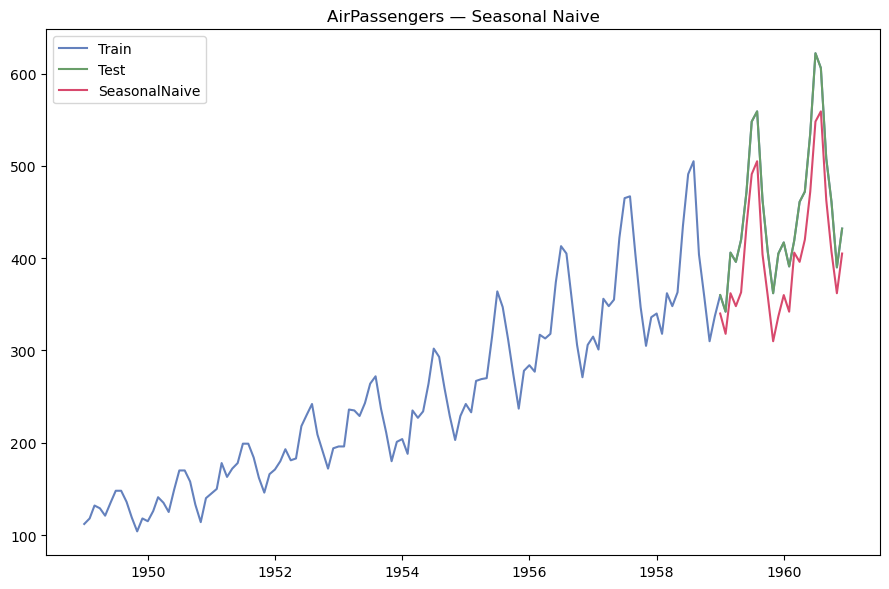

In [14]:
fc_snaive = y.shift(m).reindex(y_test.index).astype(float).rename("SeasonalNaive")
print_scores("SeasonalNaive", y_test, fc_snaive)
plot_model("AirPassengers — Seasonal Naive", y, y_test, fc_snaive)

#### ThetaModel
- 핵심 아이디어
  - 시계를 두 개의 세타 선으로 분리해 결합(수준 보정 + 추세 보정)
  - 이론적으로 SES(ETS A,N,N)+drift 와, 또 그것이 ARIMA(0,1,1)+drift와 거의 동치
- 선택 기준 
  - 강력한 기준선(baseline) 이 필요할 때
  - deseasonalize=True(지원 시)로 계절 제거 후 쓰면 깔끔
- 장점/주의
  - 초간단·매우 빠름, 튜닝 적음
  - 복잡한 계절/비선형에는 한계 → ETS/TBATS/SARIMA와 같이 비교

[Theta]  RMSE=71.361  MAPE=13.34%  sMAPE=14.48%


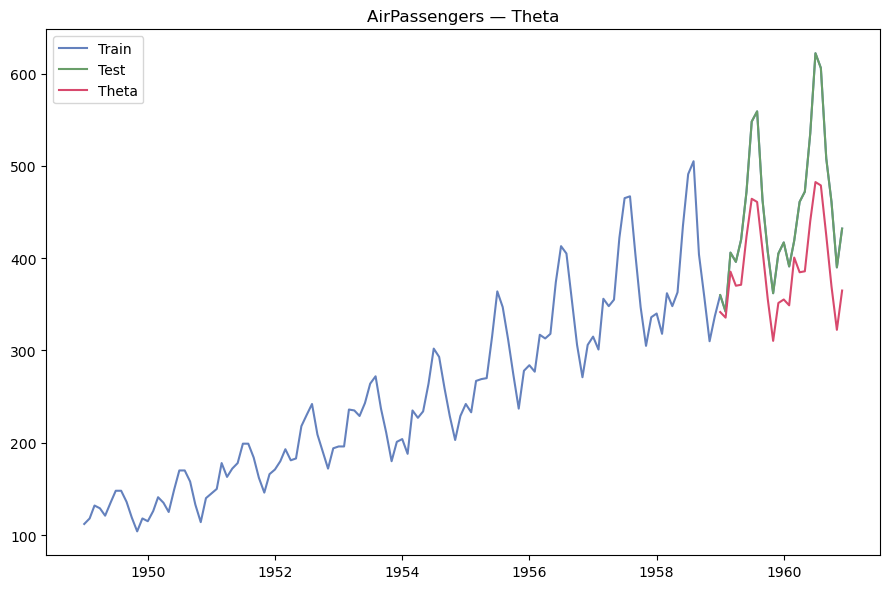

In [15]:
theta_kwargs = {}
if "deseasonalize" in signature(ThetaModel).parameters:
    theta_kwargs["deseasonalize"] = True   

theta = ThetaModel(y_train, period=m, **theta_kwargs).fit()
fc_theta = as_series(theta.forecast(len(y_test)), y_test.index, "Theta")
print_scores("Theta", y_test, fc_theta)
plot_model("AirPassengers — Theta", y, y_test, fc_theta)

#### ETS (Exponential Smoothing: Error–Trend–Seasonal)
- 상태공간 형태로 수준/추세/계절을 직접 갱신
- 오류·추세·계절을 A(dditive)/M(ultiplicative)/None으로 조합
- 선택 기준 
  - 변동이 최근 값에 더 민감하고, 계절/추세가 뚜렷할 때
  - 자동화가 쉽고 빠른 베이스라인
- 장점
  - 매끄럽고 직관적, 튜닝 파라미터(α,β,γ,φ) 해석 가능
  - 복잡한 AR 구조 없이도 계절/추세를 잘 추적
- 주의/튜닝
  - 오차의 자동상관은 명시적으로 모델링하지 않음(그게 강하면 ARIMA가 유리)
  - 가변 진폭엔 곱셈형을, 이상치엔 강건 옵션/윈저라이징 고려

[ETS(mul-mul)]  RMSE=12.917  MAPE=2.52%  sMAPE=2.54%


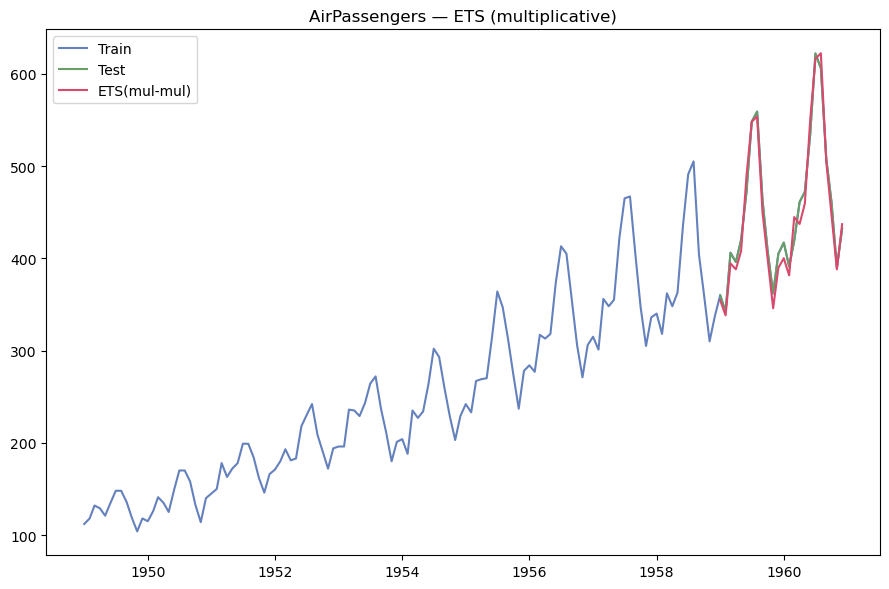

In [16]:
ets = ExponentialSmoothing(y_train, trend="mul", damped_trend=True, seasonal="mul", 
                           seasonal_periods=m, initialization_method="estimated").fit(optimized=True)

fc_ets = as_series(ets.forecast(len(y_test)), y_test.index, "ETS(mul-mul)")
print_scores("ETS(mul-mul)", y_test, fc_ets)
plot_model("AirPassengers — ETS (multiplicative)", y, y_test, fc_ets)

#### UCM (Unobserved Components, 구조적 시계열)
- 칼만 필터로 수준(level)/추세(trend)/계절(seasonal)/순환(cycle) 등을 분해해 추정
- 각 구성요소를 결정적/확률적(stochastic) 으로 선택 가능, 댐핑(damped)도 가능
- 회귀항(외생변수)도 쉽게 추가
- 선택 기준 
  - 구조가 보이는 예측 : 각 구성요소를 해석하고 싶을 때
  - 점진적 구조 변화, 국소적 추세에 강함
- 장단점
  - 해석력 / 유연성 높음
  - 구성요소가 많으면 과적합·수렴 문제 → 간결하게 시작
- 주의
  - 로그(또는 Box–Cox) / 역변환 처리 

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `stochastic_level` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `stochastic_trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


[UCM(log)]  RMSE=32.582  MAPE=5.77%  sMAPE=5.97%


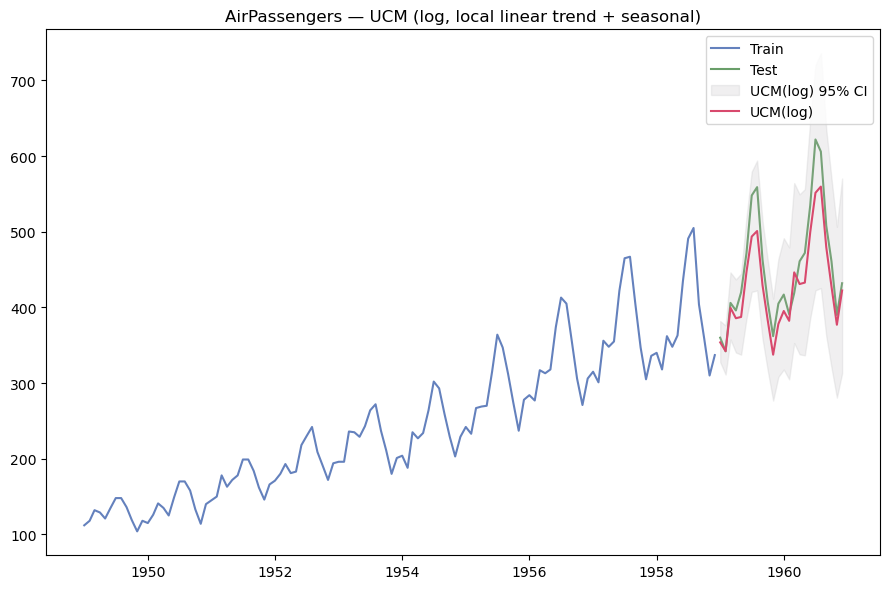

In [17]:
ytr_log = np.log(y_train)
ucm_log = UCM(ytr_log, level="local linear trend", seasonal=12, damped_trend=True, 
              stochastic_level=True, stochastic_trend=True, stochastic_seasonal=True).fit(disp=False)

pred = ucm_log.get_forecast(steps=len(y_test))
fc_log = pred.predicted_mean
ci_log = pred.conf_int(alpha=0.05)      

fc_ucm  = pd.Series(np.exp(fc_log.values), index=y_test.index, name="UCM(log)")
ci_ucm  = pd.DataFrame({"lower": np.exp(ci_log.iloc[:, 0].values),
                        "upper": np.exp(ci_log.iloc[:, 1].values)}, index=y_test.index)

print_scores("UCM(log)", y_test, fc_ucm)
plot_model("AirPassengers — UCM (log, local linear trend + seasonal)",
           y_train, y_test, fc_ucm, ci_ucm)

#### BATS / TBATS (다중 계절성)
- **B**ox–Cox + **A**RMA errors + **T**rend(+damped) + **S**easonality(삼각함수)
- TBATS는 다중/긴 주기(예: 7·365.25 같이 여러 주기)를 동시에 다룸
- 선택 기준 
  - 여러 계절성(하루·주·연), 비정수 주기나 긴 주기가 있는 데이터
  - 복잡 계절 구조에서 ETS/SARIMA보다 유리할 때가 많음
- 주의
  - 비교적 학습이 무겁고 작은 데이터에서 과적합 우려
  - 기본은 가법이지만 Box-Cox로 곱셈적 패턴에 대응

[TBATS]  RMSE=70.267  MAPE=12.83%  sMAPE=13.93%


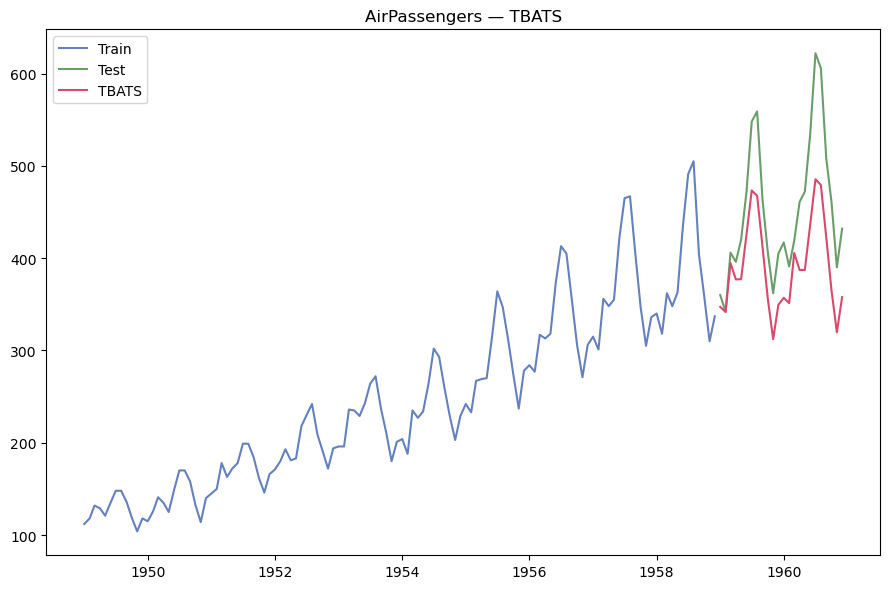

In [18]:
tbats_model = TBATS(seasonal_periods=[12], use_box_cox=True, use_trend=True,
                    use_damped_trend=True).fit(y_train)

fc_tbats = as_series(tbats_model.forecast(steps=len(y_test)), y_test.index, "TBATS")
print_scores("TBATS", y_test, fc_tbats)
plot_model("AirPassengers — TBATS", y_train, y_test, fc_tbats)

[TBATS] selected by AIC = 1115.68
Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.781297
Trend (Beta): 0.041725
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-3.63131730e-07  1.58685703e-07]
AR coefficients []
MA coefficients []
Seed vector [ 4.81008337 -0.00813542 -0.14212595  0.05389597 -0.01044897  0.00814232
  0.00502465  0.02934449  0.06104935 -0.02634057 -0.03503377 -0.02082088]

AIC 1115.675665
[TBATS(best)]  RMSE=57.240  MAPE=10.32%  sMAPE=11.03%


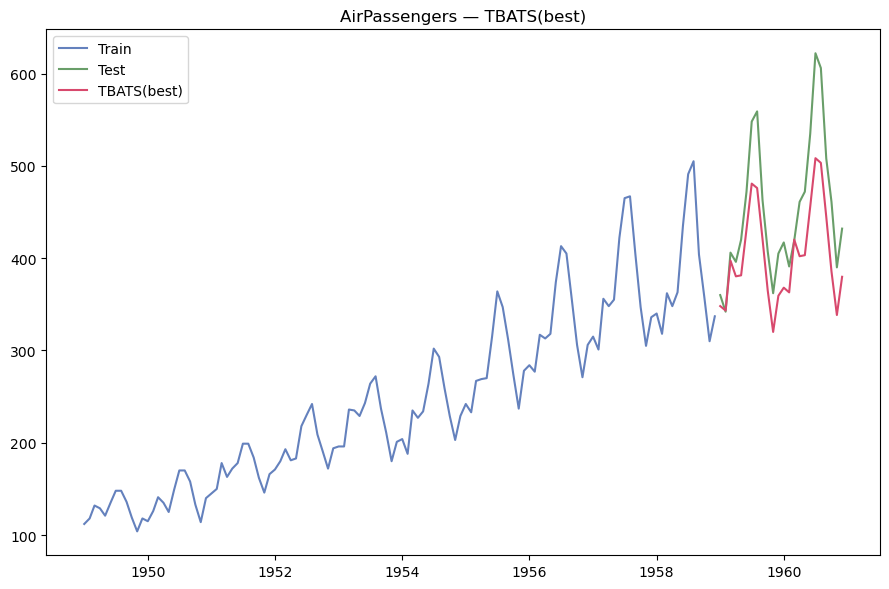

In [19]:
candidates = [TBATS(seasonal_periods=[12], use_box_cox=True, use_arma_errors=True),            
              TBATS(seasonal_periods=[12], use_box_cox=True, use_trend=True,
                    use_damped_trend=True, use_arma_errors=True),                              
              TBATS(seasonal_periods=[24], use_box_cox=True, use_arma_errors=True),                                                   
              BATS(seasonal_periods=[12], use_box_cox=True, use_arma_errors=True)]

best_fit, best_name, best_aic = None, None, float('inf')
for model in candidates:
    fit = model.fit(y_train)
    if fit.aic < best_aic:
        best_fit, best_aic = fit, fit.aic
        best_name = type(model).__name__

print(f"[{best_name}] selected by AIC = {best_aic:.2f}")
print(best_fit.summary()) 

fc_best = pd.Series(best_fit.forecast(steps=len(y_test)), index=y_test.index, name=f"{best_name}(best)")
print_scores(f"{best_name}(best)", y_test, fc_best)
plot_model(f"AirPassengers — {best_name}(best)", y_train, y_test, fc_best)

#### STL + ARIMA
- STL(LOESS로 강건한 계절 분해)로 계절성 제거 → 나머지(추세/불규칙)에 ARIMA 적합 → 예측 후 계절 성분 재합성
- 선택 기준 
  - 계절 패턴이 서서히 변형되거나, 이상치/추세가 뒤섞인 경우
  - 분해가 명확하여 해석·디버깅이 쉬움
- 팁
  - 곱셈적이면 로그 후 STL(additive 분해) → 역변환
  - 윈도우/강건 옵션으로 계절 변화에 대응

[STL+ARIMA(1,1,1)]  RMSE=73.093  MAPE=14.36%  sMAPE=15.68%


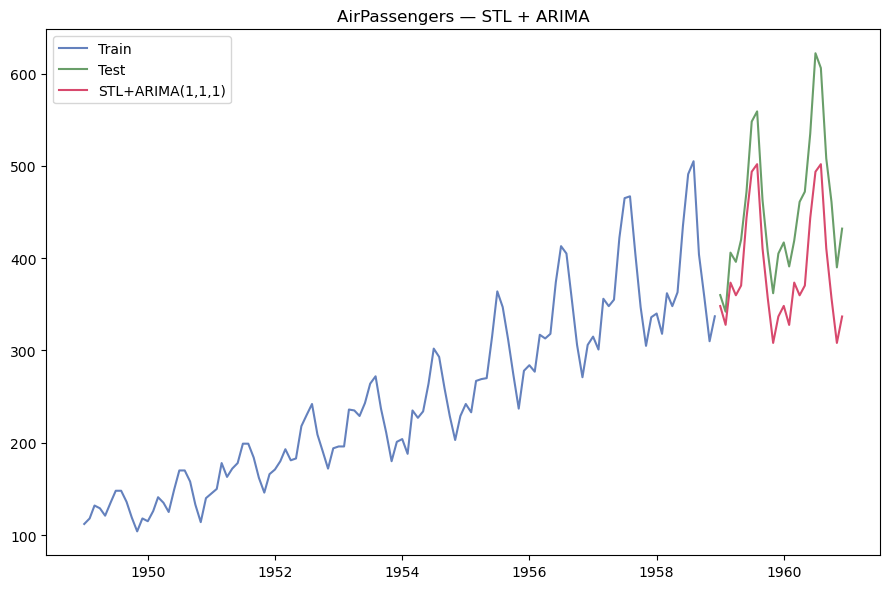

In [20]:
stl_arima = STLForecast(y_train, ARIMA, period=12, model_kwargs={"order": (1, 1, 1)}).fit()

fc_stl_arima = as_series(stl_arima.forecast(len(y_test)), y_test.index, "STL+ARIMA(1,1,1)")
print_scores("STL+ARIMA(1,1,1)", y_test, fc_stl_arima)
plot_model("AirPassengers — STL + ARIMA", y_train, y_test, fc_stl_arima)

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Adm

       order trend       RMSE   MAPE(%)  sMAPE(%)
0  (2, 1, 2)     t  18.290620  3.462211  3.543922
1  (1, 1, 2)     t  18.373034  3.473876  3.556417
2  (1, 1, 1)     t  18.630441  3.521235  3.606479
3  (0, 1, 2)     t  18.836814  3.566130  3.653582
4  (0, 1, 1)     t  19.522531  3.728211  3.823036
5  (2, 1, 1)     t  19.557178  3.736362  3.831535
6  (2, 0, 1)     c  20.056347  3.849361  3.949361
7  (2, 1, 0)     t  20.556299  3.966022  4.072265
8  (1, 1, 0)     t  21.069784  4.094866  4.206922
9  (0, 1, 0)     t  22.193341  4.372036  4.497167
Best: (2, 1, 2) trend: t RMSE: 18.291
[STL+ARIMA(2, 1, 2)(log,t)]  RMSE=18.291  MAPE=3.46%  sMAPE=3.54%


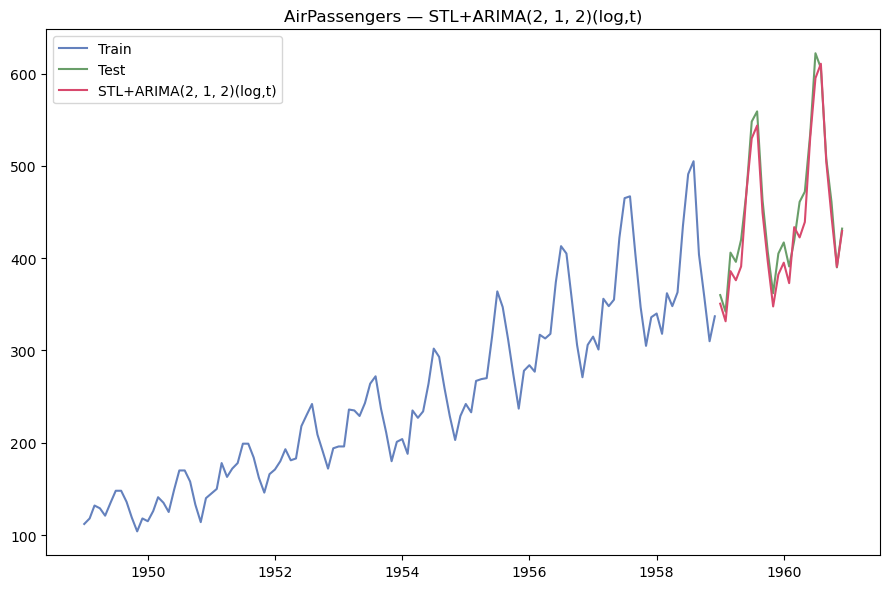

In [23]:
ytr_log = np.log(y_train)
orders = [(p,d,q) for p in [0,1,2] for d in [0,1] for q in [0,1,2] if not (p==0 and d==0 and q==0)]

best = None
rows = []

for (p, d, q) in orders:
    trend_opt = "c" if d == 0 else "t"  
    fit = STLForecast(ytr_log, ARIMA, period=12, robust=True,
                      model_kwargs={"order": (p, d, q), "trend": trend_opt, "enforce_stationarity": False,
                                    "enforce_invertibility": False}).fit()

    fc_log = fit.forecast(len(y_test))
    fc = pd.Series(np.exp(np.asarray(fc_log).ravel()),
                   index=y_test.index, name=f"STL+ARIMA{(p,d,q)}")

    r = rmse(y_test, fc); m = mape(y_test, fc); s = smape(y_test, fc)
    rows.append({"order": (p, d, q), "trend": trend_opt,
                 "RMSE": r, "MAPE(%)": m, "sMAPE(%)": s, "fc": fc})

    if (best is None) or (r < best["RMSE"]):
        best = rows[-1]

score_stl = pd.DataFrame(rows).drop(columns="fc").sort_values("RMSE").reset_index(drop=True)
print(score_stl.head(10))
print("Best:", best["order"], "trend:", best["trend"], "RMSE:", round(best["RMSE"], 3))

fc_stl_arima_best = best["fc"].rename(f"STL+ARIMA{best['order']}(log,{best['trend']})")
print_scores(fc_stl_arima_best.name, y_test, fc_stl_arima_best)
plot_model(f"AirPassengers — {fc_stl_arima_best.name}", y_train, y_test, fc_stl_arima_best)

#### 모델 비교
- ETS(mul–mul) — 1위
  - AirPassengers는 수준↑ ⇒ 계절 진폭도 ↑ 인 곱셈형 계절성이라 ETS의 M–M 구조에 적합
  - 최근 관측에 더 큰 가중을 주는 지수 평활 특성 
- STL+ARIMA (로그, 튜닝) — 2위
  - 로그 → STL(가법 분해) 로 계절을 제거하고, 남은 비계절 성분을 작은 차수 ARIMA로 잡아줌
  - 계절/추세를 직접 상태로 추적하는 ETS만큼 민첩하진 않음
- UCM(log) — 3위
  - 로그 스케일에서 수준/추세/계절을 상태공간으로 분해·추적   
    → 구조적 유연성은 크지만, 학습 데이터가 길지 않아 ETS 대비 민감도에서 약간 밀림
- SARIMA(boxcox, auto) — 중위권
  - 선택된 모형이 (2,0,0)(0,1,0)[12]처럼 계절 AR/MA가 없는 단순 구조   
    계절차분(D=1) 후 AR(2)만으로는 증가하는 진폭과 피크를 약간 과소추정
- Seasonal Naive — 베이스라인
  - 추세 가속을 반영 못 해 중위권
- TBATS(best) — 하위권
  - 장점은 다중/긴/비정수 계절성에서 나오는데, 이 데이터는 단일 12개월 계절이라 이점을 못 살림
  - 자동선택 결과도 ARMA-errors가 0,0이라 단순해짐
- Theta — 하위권
  - 급격히 커지는 진폭엔 한계


========== Model Score Comparison ==========
        Model      RMSE   MAPE(%)  sMAPE(%)
 ETS(mul-mul) 12.916587  2.524553  2.540212
    STL+ARIMA 18.290620  3.462211  3.543922
          UCM 32.581875  5.772090  5.971218
 SARIMA(auto) 47.226392  9.439333  9.968721
SeasonalNaive 49.986665 10.522728 11.166613
        TBATS 57.240471 10.323493 11.030867
        Theta 71.360963 13.343084 14.476361


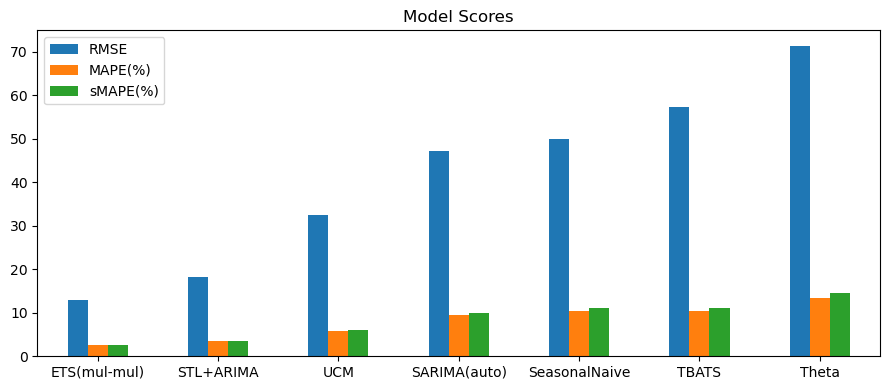

In [24]:
def collect_scores(y_test, preds_dict):
    rows = []
    for name, pred in preds_dict.items():
        s = pd.Series(np.asarray(getattr(pred, "values", pred)).ravel(),
                      index=y_test.index, name=name, dtype="float64")
        rows.append({"Model": name, "RMSE": rmse(y_test, s),
                     "MAPE(%)": mape(y_test, s), "sMAPE(%)": smape(y_test, s)})
    df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
    return df

preds_dict = {"SARIMA(auto)": fc_sarima, "SeasonalNaive": fc_snaive, "Theta": fc_theta, 
              "ETS(mul-mul)": fc_ets, "UCM":fc_ucm , "TBATS":fc_best, "STL+ARIMA":fc_stl_arima_best}

score_df = collect_scores(y_test, preds_dict)
print("\n========== Model Score Comparison ==========")
print(score_df.to_string(index=False))

ax = score_df.set_index("Model")[["RMSE","MAPE(%)","sMAPE(%)"]].plot(kind="bar", figsize=(9,4))
ax.set_title("Model Scores")
ax.set_xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 변동성 모델(GARCH)
- AirPassengers 월별 로그수익률 r = 100*np.log(y).diff()에는 보통 금융시계열처럼 강한 변동성 클러스터링이 없음

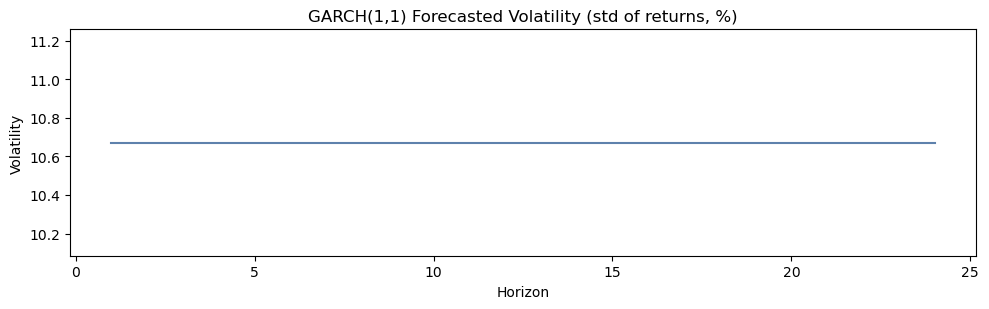

In [25]:
r = 100 * np.log(y).diff().dropna()
garch = arch_model(r, mean="Constant", vol="GARCH", p=1, q=1, dist="t").fit(disp="off")
vol = np.sqrt(garch.forecast(horizon=len(y_test), reindex=False).variance.values[-1])

plt.figure(figsize=(10,3.2))
plt.plot(range(1, len(y_test)+1), vol, color="#5E81AC")
plt.title("GARCH(1,1) Forecasted Volatility (std of returns, %)")
plt.xlabel("Horizon")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()

---

# 2. sp500 데이터셋을 이용한 금융 시계열 예측 

### 데이터 로드

In [26]:
data = sp500.load()                                
prices = data['Adj Close'].dropna()
r = 100 * np.log(prices).diff().dropna()  

### Train / Test Split

In [27]:
test_len = 500
h = 50
r_train, r_test = r.iloc[:-test_len], r.iloc[-test_len:]

print("Train:", r_train.index.min().date(), "→", r_train.index.max().date(), "| N:", len(r_train))
print("Test :", r_test.index.min().date(),  "→", r_test.index.max().date(),  "| N:", len(r_test))

Train: 1999-01-05 → 2017-01-04 | N: 4530
Test : 2017-01-05 → 2018-12-31 | N: 500


### ARCH 효과 검정(Train)
- ARCH LM p-value = 2.971e-269
  - 귀무가설(조건부 이분산 없음)을 강하게 기각
  - ARCH 효과가 매우 강함 = 변동성 클러스터링 존재
- Ljung–Box on r² (lags 10, 20) p-value = 0.0
  - 제곱수익률에 유의한 자기상관이 남아 있음
  - 변동성이 시간에 따라 묶여 움직인다는 추가 증거

In [28]:
# ARCH LM: 조건부 이분산(변동성 클러스터링) 유무
lm_stat, lm_pval, _, _ = het_arch(r_train, nlags=12)

# 제곱수익률의 Ljung–Box: 변동성 클러스터링 신호
print(f"ARCH LM p-value (12 lags): {lm_pval:.4g}")
print("LB test on squared returns:\n", acorr_ljungbox(r_train**2, lags=[10, 20], return_df=True))

ARCH LM p-value (12 lags): 2.971e-269
LB test on squared returns:
         lb_stat  lb_pvalue
10  3682.305467        0.0
20  6332.406392        0.0


### 모델 적합
- index-safe: last_obs=r_train.index[-1]
- 전체 r에 대해 적합하되, 추정은 last_obs까지로 제한 → 예측 결과가 DatetimeIndex로 정렬됨

In [29]:
# GARCH(1,1) + t-분포
arch1 = arch_model(r, mean='Constant', vol='ARCH', p=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

# 비교용: ARCH(1)
garch11 = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

### 모델 비교
- 모형 선택 (AIC/BIC) → GARCH
  - AIC/BIC 차이가 800+: 압도적 우위(>10이면 강한 증거)
- GARCH(1,1) 추정치 해석
  - Mean(μ) = 0.0602 (단위: %/day), p≪0.01 → 유의   
    연환산 대략 15% (0.0602×252)
  - Volatility model (GARCH)
    - ω=0.0136, α₁=0.0186, β₁=0.8964 (모두 유의)
    - 지속성 α+β ≈ 0.915 → 충격의 여운이 매우 지속적(하지만 <1이므로 정상성 유지)
    - 장기 분산/변동성   
      $\sigma_\infty^2 = \frac{0.0136}{1-0.915} = 0.1600, \qquad \sigma_\infty   = \sqrt{0.1600} = 0.40\%, \qquad \sigma_{\text{ann}} = \sqrt{252}\times 0.40\% \approx 6.35\%$
- 분포: Student’s t, df≈7.4 → 꼬리가 두꺼움(정규보다 극단값 빈도 큼)
- Covariance estimator: robust → 표준오차를 강건하게 계산

In [30]:
comp = pd.DataFrame({"AIC": [arch1.aic, garch11.aic], "BIC": [arch1.bic, garch11.bic]}, 
                    index=["ARCH(1)", "GARCH(1,1)"])

print("=========== Model comparison ==========")
print(comp)

print("\nGARCH(1,1) summary (truncated):")
print(garch11.summary())

=========== Model comparison ==========
                     AIC           BIC
ARCH(1)     13576.573527  13602.246553
GARCH(1,1)  12748.507789  12780.599071

GARCH(1,1) summary (truncated):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6369.25
Distribution:      Standardized Student's t   AIC:                           12748.5
Method:                  Maximum Likelihood   BIC:                           12780.6
                                              No. Observations:                 4529
Date:                      Thu, Sep 11 2025   Df Residuals:                     4528
Time:                              17:02:56   Df Model:                            1
                                 Mean Model  

### 조건부 변동성(1-step) 경로 & h-step 예측

In [31]:
# 인덱스 안전성 : last_obs로 학습구간을 고정, 예측은 전체 인덱스
garch11_full = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t').fit(last_obs=r_train.index[-1], disp='off')

# 테스트 구간 전체의 1-step ahead 경로
f_1 = garch11_full.forecast(horizon=1, reindex=True) 
vol_1step = np.sqrt(f_1.variance['h.1']).loc[r_test.index] 
vol_1step.name = "GARCH(1,1) 1-step vol (%)"

# 테스트 시작일에서의 h-step 고정지평 예측
h = 50
f_h = garch11_full.forecast(horizon=h, start=r_test.index[0], reindex=True)
vol_h = np.sqrt(f_h.variance.loc[r_test.index[0]]) 
vol_h.index = pd.Index([int(c.split('.')[-1]) for c in vol_h.index], name='Horizon')
vol_h.name = "GARCH(1,1) h-step vol (%)"

### 장기(steady-state) 변동성
- α+β = 0.993
  - 변동성의 지속성(persistence) 이 매우 강함을 의미
  - 1보다 작으므로 정상성은 유지하지만, IGARCH에 가까운 수준이라 충격이 천천히 사라짐
- Long-run volatility ≈ 1.404%/day
  - 하루 수익률의 평균적 변동 폭이 약 1.4%

In [32]:
params = garch11.params
alpha = float(params.filter(like='alpha').sum())
beta  = float(params.filter(like='beta').sum())
omega = float(params['omega'])
phi = alpha + beta
long_run_vol = np.sqrt(omega / (1 - phi)) if phi < 1 else np.nan

print(f"alpha+beta = {phi:.3f}")
print(f"Long-run volatility ≈ {long_run_vol:.3f}%")

alpha+beta = 0.993
Long-run volatility ≈ 1.404%


### 시각화
- 1-step 조건부 변동성(테스트 기간)
  - 매일 내일의 변동성을 예측한 경로
  -2018-02 전후(일명 Volmageddon)와 2018년 4분기 급락 구간에 급격한 스파이크가 보이고, 그 뒤로 서서히 감쇠
  - 스파이크 후 완만히 내려오는 모습은 GARCH의 지속성(α+β가 1에 근접) 을 반영한 것—충격의 여운이 오래 남음 
- h-step 고정지평 예측
  - 테스트 시작 시점에서 1~50일 앞의 변동성을 예측한 곡선
  - 단조 증가 → 장기(무조건) 변동성 쪽으로 수렴하는 모습이 정석적인 GARCH(1,1) 예측
  - 수렴이 느린 이유: 𝛼 + 𝛽 가 매우 커서(≈1) 반감기가 김 

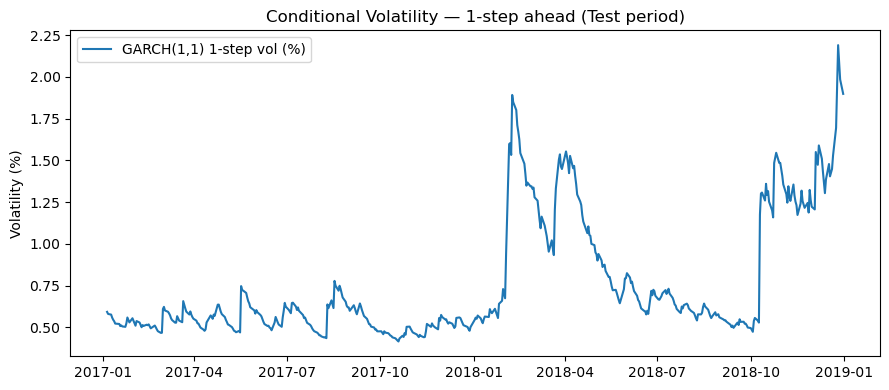

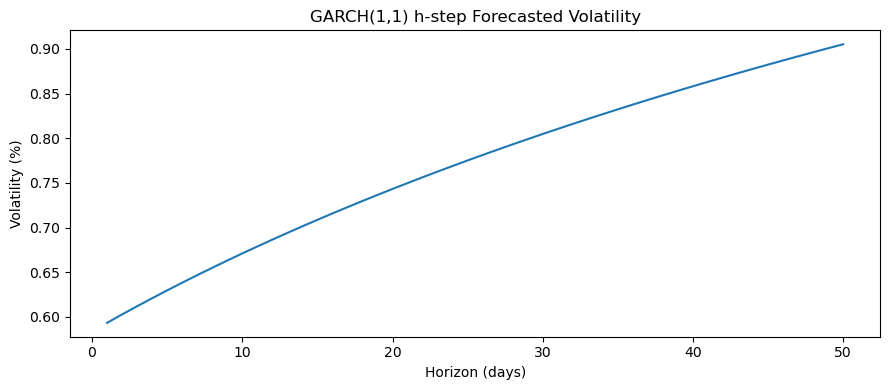

In [33]:
plt.figure(figsize=(9, 4))
plt.plot(r_test.index, vol_1step.values, label=vol_1step.name)
plt.title("Conditional Volatility — 1-step ahead (Test period)")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(vol_h.index, vol_h.values)
plt.title("GARCH(1,1) h-step Forecasted Volatility")
plt.xlabel("Horizon (days)")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()